In [1]:
from fusion_model import CombinedModel

import torch
from MRIdata import MRIdataset
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler

%reload_ext autoreload
%autoreload 2

dataPath = 'E:/data/CLAHE_data_st_yz_xah/tumor+1cm/YZ_XAH_images/BCS_margin_data'
trainDataset = MRIdataset(dataPath, 'train')
valDataset = MRIdataset(dataPath, 'val')
testDataset = MRIdataset(dataPath, 'test')

C:\Users\Xue\.conda\envs\WSI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# 修改后的 test 函数，增加准确率输出并保存预测结果
def train(model, dataset, dataset_name):
    y_pred = []
    y_true = []
    y_score = []

    dataset.prepared = False
    model.eval()
    for d in DataLoader(dataset, batch_size=5):
        inputs = d['image'].cuda()
        inputs2 = d['margin'].cuda()
        labels = d['label'].cuda()
        IDs = d['ID']

        outputs = model(inputs, inputs2)
        outputs = outputs.detach()

        y_pred += torch.argmax(outputs, 1).tolist()
        y_true += labels.tolist()
        y_score += F.softmax(outputs, dim=1)[:, 1].tolist()

    y_pred = torch.tensor(y_pred)
    y_true = torch.tensor(y_true)
    y_score = torch.tensor(y_score)

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_true, y_pred)

    return auc_score, accuracy, confusion_matrix(y_true, y_pred, normalize='true')

In [5]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, WeightedRandomSampler
import copy

# 修改后的 test 函数，增加准确率输出并保存预测结果
def test(model, dataset, dataset_name):
    y_pred = []
    y_true = []
    y_score = []
    patient_ids = []  # 用于存储患者ID

    dataset.prepared = False
    model.eval()
    for d in DataLoader(dataset, batch_size=5):
        inputs = d['image'].cuda()
        inputs2 = d['margin'].cuda()
        labels = d['label'].cuda()
        IDs = d['ID']

        outputs = model(inputs, inputs2)
        outputs = outputs.detach()

        y_pred += torch.argmax(outputs, 1).tolist()
        y_true += labels.tolist()
        y_score += F.softmax(outputs, dim=1)[:, 1].tolist()
        patient_ids += IDs  # 添加患者ID到列表

    y_pred = torch.tensor(y_pred)
    y_true = torch.tensor(y_true)
    y_score = torch.tensor(y_score)

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_true, y_pred)

    # 保存预测结果
    results_df = pd.DataFrame({
        'ID':patient_ids,
        'True_Label': y_true.tolist(),
        'Predicted_Label': y_pred.tolist(),
        'Predicted_Score': y_score.tolist()
    })
    results_df.to_csv(f'{dataset_name}_predictions.csv', index=False)

    return auc_score, accuracy, confusion_matrix(y_true, y_pred, normalize='true'), fpr, tpr

In [23]:
torch.cuda.set_device(0)  # 在有多个GPU时指定某个GPU
model = CombinedModel(8)
model.cuda()

criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1., 2.]).cuda())
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
trainDataset.setDataWeight(1, 3)
trainDataset.prepared = True
trainSampler = WeightedRandomSampler(trainDataset.dataWeightList, 500, replacement=True)
trainDataLoader = DataLoader(trainDataset, batch_size=10, sampler=trainSampler)

# 训练与评估
bestcm = 0
best_model = None
total_epochs = 30

train_auc_history = []
val_auc_history = []

print('Training start')
for epoch in range(total_epochs):
    model.train()
    for d in trainDataLoader:
        inputs1 = d['image'].cuda()
        inputs2 = d['margin'].cuda()
        labels = d['label'].cuda()
        IDs = d['ID']

        outputs = model(inputs1, inputs2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # 在每个 epoch 后测试模型
    tr_auc, tr_acc, tr_cm = train(model, trainDataset, 'train')
    v_auc, v_acc, v_cm = train(model, valDataset, 'val')
    te_auc, te_acc, te_cm = train(model, testDataset, 'test')

    print(
        epoch,
        f'train {tr_cm[0, 0] + tr_cm[1, 1]:.3f}',f'{tr_acc:.3f}',
        f'val {v_cm[0, 0] + v_cm[1, 1]:.3f}',f'{v_acc:.3f}',
        f'test {te_cm[0, 0] + te_cm[1, 1]:.3f}',f'{te_acc:.3f}',
    )

    # train_auc_history.append(tr_auc)
    # val_auc_history.append(v_auc)

    v_cm_sum = v_cm[0, 0] + v_cm[1, 1]
    #print(v_cm_sum)

    if v_cm_sum > bestcm:
        bestcm = v_cm_sum
        bestmodel = copy.deepcopy(model)
        print('update best')
print('Training end')

Training start


C:\Users\Xue\.conda\envs\WSI\lib\site-packages\torchio\data\image.py:248: UserWarning: Using TorchIO images without a torchio.SubjectsLoader in PyTorch >= 2.3 might have unexpected consequences, e.g., the collated batches will be instances of torchio.Subject with 5D images. Replace your PyTorch DataLoader with a torchio.SubjectsLoader so that the collated batch becomes a dictionary, as expected. See https://github.com/fepegar/torchio/issues/1179 for more context about this issue.
  warnings.warn(message, stacklevel=1)


0 train 1.000 0.865 val 1.000 0.867 test 1.000 0.812
update best
1 train 1.000 0.865 val 1.000 0.867 test 1.000 0.812
2 train 1.043 0.854 val 1.022 0.856 test 0.923 0.750
update best
3 train 1.157 0.867 val 1.108 0.872 test 1.256 0.812
update best
4 train 1.040 0.863 val 1.080 0.878 test 1.000 0.812
5 train 1.332 0.860 val 1.419 0.878 test 0.949 0.562
update best
6 train 1.482 0.820 val 1.431 0.830 test 0.897 0.312
update best
7 train 1.394 0.865 val 1.360 0.856 test 1.179 0.750
8 train 1.243 0.881 val 1.268 0.894 test 1.333 0.875
9 train 1.436 0.865 val 1.366 0.862 test 1.026 0.625
10 train 1.137 0.874 val 1.200 0.894 test 1.000 0.812
11 train 1.541 0.858 val 1.403 0.835 test 0.641 0.312
12 train 1.127 0.865 val 1.188 0.883 test 1.000 0.812
13 train 1.527 0.761 val 1.459 0.766 test 1.308 0.438
update best
14 train 1.424 0.599 val 1.306 0.574 test 1.000 0.188
15 train 1.003 0.137 val 1.000 0.133 test 1.000 0.188
16 train 1.471 0.908 val 1.237 0.867 test 1.103 0.688
17 train 1.172 0.284

In [6]:
bestmodel = torch.load('20250310models_new/bestRES_1.502_acc0.745_auc0.80/bestRES_1.502_acc0.745.pt', weights_only=False)
#best_1.437_auc0.782/bestRES_1.437
#best_1.478_auc0.797/bestRES_1.478
tr_auc, tr_acc, tr_cm, tr_fpr, tr_tpr = test(bestmodel, trainDataset, 'train')
v_auc, v_acc, v_cm, v_fpr, v_tpr = test(bestmodel, valDataset, 'val')
te_auc, te_acc, te_cm, te_fpr, te_tpr = test(bestmodel, testDataset, 'test')

print(
	f'train {tr_auc:.3f} [{tr_cm[0,0]:.3f} {tr_cm[1,1]:.3f}]',
	f'val {v_auc:.3f} [{v_cm[0,0]:.3f} {v_cm[1,1]:.3f}]',
	f'test {te_auc:.3f} [{te_cm[0,0]:.3f} {te_cm[1,1]:.3f}]',
)
print(f'acc: train {tr_acc:.3f}',f'val {v_acc:.3f} ',f'test {te_acc:.3f} ')
#torch.save(bestmodel, 'bestRES_1.406_acc0.867_auc.pt')

train 0.859 [0.695 0.817] val 0.800 [0.742 0.760] test 0.528 [0.095 0.830]
acc: train 0.712 val 0.745  test 0.300 


In [7]:
# 绘制 ROC 曲线的函数
def plot_roc_curve(fpr, tpr, dataset_name,color,ls):
    plt.plot(fpr, tpr,color=color,ls=ls, label=f'{dataset_name} (AUC = {auc(fpr, tpr):.3f})')

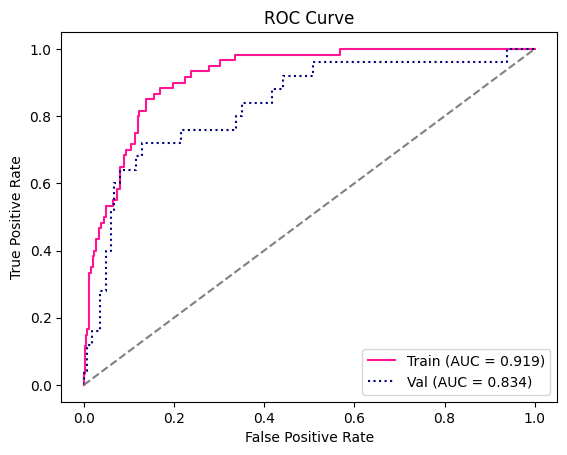

In [6]:
# 绘制 ROC 曲线
plt.figure()
plot_roc_curve(tr_fpr, tr_tpr, 'Train',color="deeppink",ls='-')
plot_roc_curve(v_fpr, v_tpr, 'Val',color="navy",ls=':')
# 添加对角线（虚线）
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('roc_curve.png')
plt.show()

In [9]:
def plot_roc_curve(fpr, tpr,dataset_name, color='deeppink'):
    plt.plot(fpr, tpr, color=color, label=f'{dataset_name} (AUC = {auc(fpr, tpr):.3f})')


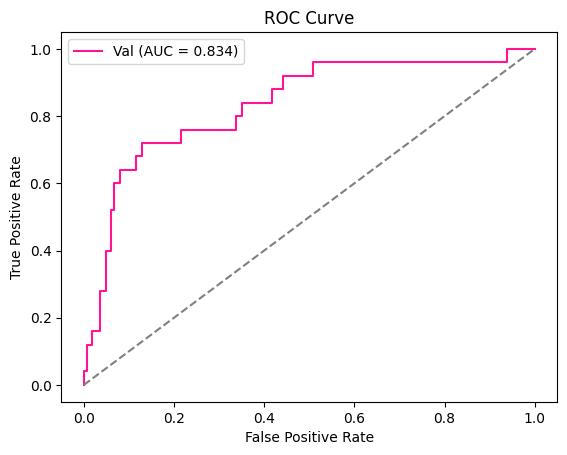

In [8]:
# 绘制 ROC 曲线
plt.figure()
plot_roc_curve(v_fpr, v_tpr, 'Val')
# 添加对角线（虚线）
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('roc_curve_val.png')
plt.show()

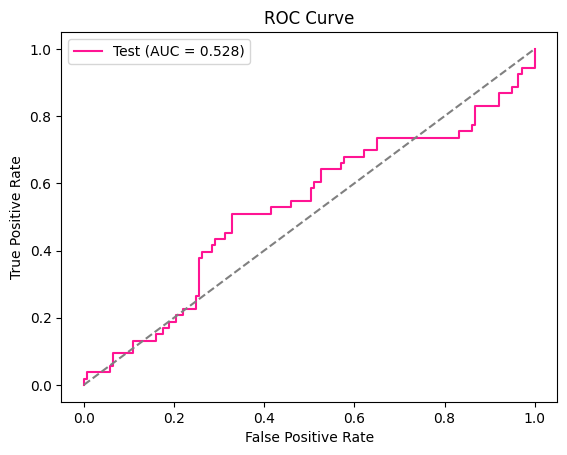

In [10]:
# 绘制 ROC 曲线
plt.figure()
plot_roc_curve(te_fpr, te_tpr, 'Test')
# 添加对角线（虚线）
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('roc_curve_test.png')
plt.show()

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

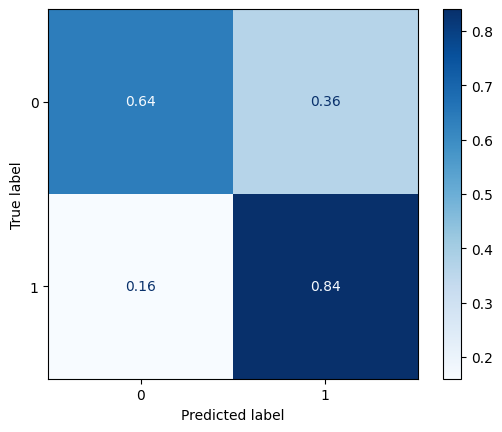

In [10]:
#plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=v_cm)
disp.plot(cmap='Blues')
plt.savefig('cm_val.png')
plt.show()

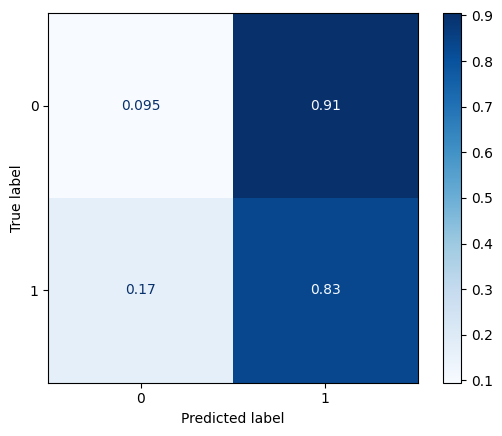

In [12]:
disp = ConfusionMatrixDisplay(confusion_matrix=te_cm)
disp.plot(cmap='Blues')
plt.savefig('cm_test.png')
plt.show()